# Abstract

In this project, we try to building a model that combining wavelet denoising and Artificial Neural Network. Using this model, we will predict stock price of Apple Inc. Then, we will evaluate model's performance using evaluation metrics.

At first, stock price data will be processed using wavelet denoising. Then we get denoised stock price data. Using this denoised data, we train neural network model. After training, we test the model and evaluate its performance using several evaluation metrics (Mean Absolute Error, Mean Absolute Percentage Error, Mean Squared Error, Root Mean Squared Error and R2 score.

# Importing needed packages

In this project, I use several packages. The version of each packages I used are listed below. 

- yfinance==0.1.74
- tensorflow==2.9.1
- scikit-learn==1.2.1
- PyWavelets==1.1.1
- pandas==1.0.5
- numpy==1.23.1
- matplotlib==3.2.2
- keras==2.9.0

In [11]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
import pywt
from pywt import wavedec
from pywt import waverec
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [12]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

# Getting stock's data and pre-processing

In [13]:
#getting Apple Inc. stock data from yfinance for April 1st,2020 throgh March 31st,2022
stock = 'AAPL' #stock's ticker
stock_data = yf.download(stock, start='2020-04-01', end='2022-04-01')
stock_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-03-31,63.900002,65.622498,63.000000,63.572498,62.428360,197002000
2020-04-01,61.625000,62.180000,59.782501,60.227501,59.143562,176218400
2020-04-02,60.084999,61.287498,59.224998,61.232498,60.130470,165934000
2020-04-03,60.700001,61.424999,59.742500,60.352501,59.266312,129880000
2020-04-06,62.724998,65.777496,62.345001,65.617500,64.436554,201820400


In [14]:
#in this project, we use only closing price to train and test the model
#in that case, we only need closing price data

#taking closing price data
stock_price = stock_data['Close']
stock_price

Date
2020-03-31     63.572498
2020-04-01     60.227501
2020-04-02     61.232498
2020-04-03     60.352501
2020-04-06     65.617500
                 ...    
2022-03-25    174.720001
2022-03-28    175.600006
2022-03-29    178.960007
2022-03-30    177.770004
2022-03-31    174.610001
Name: Close, Length: 506, dtype: float64

In [15]:
train_size = 0.8 #train:test ratio is 4:1

#splitting the training and test data
train = stock_price[:round(len(stock_price)*train_size)]
test = stock_price[round(len(stock_price)*train_size):]

# Denoising using Discrete Wavelet Transform and Inverse Discrete Wavelet Transform

In [16]:
#initiate wavelet type and wavelet decomposition level variables
level = 2 #wavelet transform decomposition level
wavelet = 'db2' #wavelet type. here we choose wavelet Daubechies 2 (db2)

In [17]:
#making function for calculating mean absolute deviation for thresholding
def mad(d, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

In [18]:
#wavelet denoising consists of three parts: decomposition, thresholding, reconstruction

In [19]:
#decompositon/Discrete Wavelet Transform
level = int(level)
wavelet = wavelet
coeff = wavedec(train, wavelet, level=level)

In [20]:
#thresholding
sigma = mad(coeff[-level])/0.6745
threshold = sigma * np.sqrt(2*np.log(len(train)))
coeff[1:] = (pywt.threshold(i, value=threshold, mode="soft") for i in coeff[1:])

In [21]:
#reconstruction/Inverse Discrete Wavelet Transform
denoised = waverec(coeff, wavelet)

In [22]:
train = train.reset_index()

In [23]:
if len(train)!=len(denoised):
    denoised = denoised[:-1]

In [24]:
train ['denoised'] = denoised

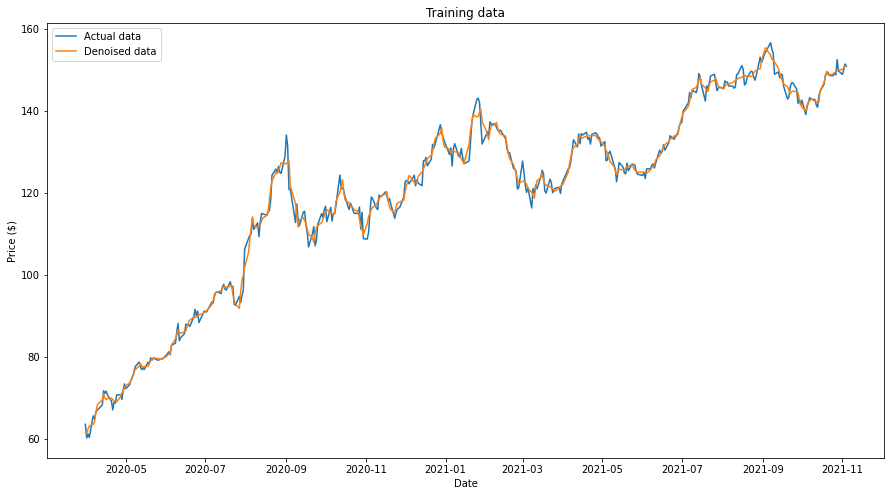

In [25]:
#plotting the actual stock price data and the denoised data
plt.figure(figsize=(15, 8))
plt.title('Training data')
plt.plot(train['Date'], train['Close'])
plt.plot(train['Date'], denoised)
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend(['Actual data', 'Denoised data'], loc='best')

# Building ANN Model

In [26]:
train = pd.DataFrame(train['denoised'])
test_df = pd.DataFrame(test)
test_df = test_df.reset_index()
test = pd.DataFrame(test_df['Close'])

In [27]:
#Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
train_scaled = sc.fit_transform(train.values.reshape(-1,1))
test_scaled = sc.fit_transform(test.values.reshape(-1,1))

In [28]:
#dividing each of training and testing data into input and output data for model training and testing

window_size = 60

X_train, y_train = [], []

for i in range(len(train_scaled)-window_size):
  a = train_scaled[i:(i+window_size), 0]
  X_train.append(a)
  y_train.append(train_scaled[i+window_size, 0])

X_train = np.array(X_train)
y_train = np.array(y_train)

X_test, y_test = [], []

for i in range(len(test)-window_size):
  a = test_scaled[i:(i+window_size), 0]
  X_test.append(a)
  y_test.append(test_scaled[i+window_size, 0])

X_test = np.array(X_test)
y_test = np.array(y_test)

In [29]:
#reshaping
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [30]:
#initiate hyperparameter values
batch = 1
epochs = 15
neuron = 40

In [31]:
#building ANN model
model = keras.Sequential()
model.add(layers.LSTM(window_size, return_sequences=True, input_shape=(window_size, 1)))
model.add(layers.LSTM(neuron, return_sequences=False))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 60)            14880     
                                                                 
 lstm_1 (LSTM)               (None, 40)                16160     
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
Total params: 31,081
Trainable params: 31,081
Non-trainable params: 0
_________________________________________________________________


In [32]:
#training model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=batch, epochs=epochs)

Epoch 1/15
345/345 [==============================] - 17s 34ms/step - loss: 0.0086
Epoch 2/15
345/345 [==============================] - 9s 27ms/step - loss: 0.0028
Epoch 3/15
345/345 [==============================] - 12s 34ms/step - loss: 0.0023
Epoch 4/15
345/345 [==============================] - 10s 28ms/step - loss: 0.0012
Epoch 5/15
345/345 [==============================] - 10s 30ms/step - loss: 0.0015
Epoch 6/15
345/345 [==============================] - 11s 32ms/step - loss: 9.3110e-04
Epoch 7/15
345/345 [==============================] - 10s 30ms/step - loss: 0.0010
Epoch 8/15
345/345 [==============================] - 9s 27ms/step - loss: 8.4576e-04
Epoch 9/15
345/345 [==============================] - 11s 32ms/step - loss: 7.0237e-04
Epoch 10/15
345/345 [==============================] - 11s 32ms/step - loss: 5.5496e-04
Epoch 11/15
345/345 [==============================] - 10s 30ms/step - loss: 4.8921e-04
Epoch 12/15
345/345 [==============================] - 10s 28ms/ste

In [33]:
pred = model.predict(X_test)
pred = sc.inverse_transform(pred)

2/2 [==============================] - 1s 16ms/step


In [34]:
y_test = y_test.reshape(len(y_test), 1)
y_test = sc.inverse_transform(y_test)

In [35]:
predict = test_df[window_size:].copy()
predict['predictions'] = pred
predict

,Date,Close,predictions
60,2022-02-02,175.839996,176.970062
61,2022-02-03,172.899994,176.031036
62,2022-02-04,172.389999,172.494308
63,2022-02-07,171.660004,172.236557
64,2022-02-08,174.830002,172.527161
65,2022-02-09,176.279999,176.650452
66,2022-02-10,172.119995,178.732452
67,2022-02-11,168.639999,172.515045
68,2022-02-14,168.880005,167.564743
69,2022-02-15,172.789993,168.637161


In [36]:
test_df

,Date,Close
0,2021-11-05,151.279999
1,2021-11-08,150.440002
2,2021-11-09,150.809998
3,2021-11-10,147.919998
4,2021-11-11,147.869995
...,...,...
96,2022-03-25,174.720001
97,2022-03-28,175.600006
98,2022-03-29,178.960007
99,2022-03-30,177.770004


In [37]:
predict=predict.set_index('Date')

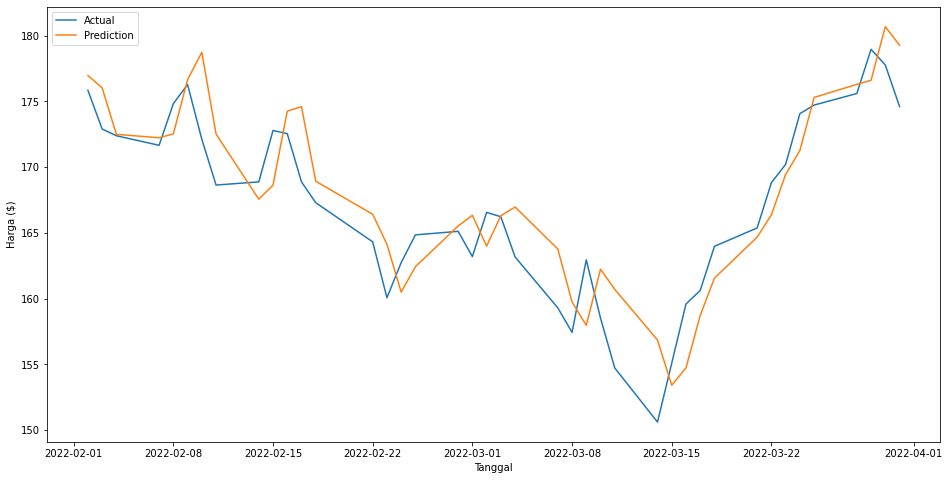

In [38]:
#plotting
plt.figure(figsize=(16,8))
plt.xlabel('Tanggal')
plt.ylabel('Harga ($)')
plt.plot(predict['Close'])
plt.plot(predict['predictions'])
plt.legend(['Actual', 'Prediction'], loc='best')
plt.show()

In [39]:
#making dataframe to save the error data
errors = pd.DataFrame(index=['MSE','RMSE', 'MAE', 'MAPE', 'R2'], columns=['Value'])

In [41]:
#calculating errors
mse = mean_squared_error(y_test, pred)
errors['Value']['MSE'] = mse

rmse = np.sqrt(mean_squared_error(y_test, pred))
errors['Value']['RMSE'] = rmse

mae = mean_absolute_error(y_test, pred)
errors['Value']['MAE'] = mae

mape = mean_absolute_percentage_error(y_test, pred)
errors['Value']['MAPE'] = mape

r2 = r2_score(y_test, pred)
errors['Value']['R2'] = r2

In [42]:
errors

,Value
MSE,10.2855
RMSE,3.20711
MAE,2.68035
MAPE,0.0162283
R2,0.78294
